In [1]:
import time

import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.utils import check_random_state
from FFNN import FFNN


In [2]:
# Turn down for faster convergence
t0 = time.time()
train_samples = 5000

# Load data from https://www.openml.org/d/554
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000
)

Sparsity with L1 penalty: 75.68%
Test score with L1 penalty: 0.8255
Example run in 98.525 s


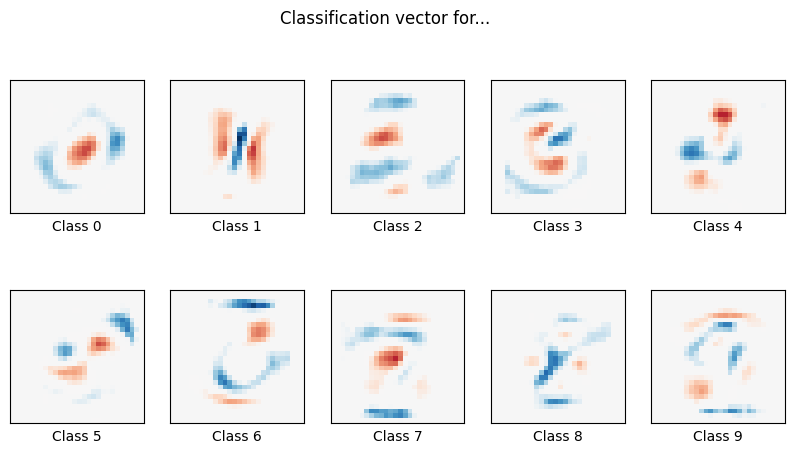

In [8]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Turn up tolerance for faster convergence
clf = LogisticRegression(C=50.0 / train_samples, penalty="l1", solver="saga", tol=0.1)
clf.fit(X_train, y_train)
sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
# print('Best C % .4f' % clf.C_)
print("Sparsity with L1 penalty: %.2f%%" % sparsity)
print("Test score with L1 penalty: %.4f" % score)

coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(
        coef[i].reshape(28, 28),
        interpolation="nearest",
        cmap=plt.cm.RdBu,
        vmin=-scale,
        vmax=scale,
    )
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel("Class %i" % i)
plt.suptitle("Classification vector for...")

run_time = time.time() - t0
print("Example run in %.3f s" % run_time)
plt.show()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

Epoch 1/20 - Train Loss: 2.0908 - Val Loss: 2.1068
Epoch 2/20 - Train Loss: 1.7758 - Val Loss: 1.8125
Epoch 3/20 - Train Loss: 1.5362 - Val Loss: 1.5811
Epoch 4/20 - Train Loss: 1.3508 - Val Loss: 1.4006
Epoch 5/20 - Train Loss: 1.2080 - Val Loss: 1.2630
Epoch 6/20 - Train Loss: 1.0949 - Val Loss: 1.1521
Epoch 7/20 - Train Loss: 1.0041 - Val Loss: 1.0648
Epoch 8/20 - Train Loss: 0.9294 - Val Loss: 0.9939
Epoch 9/20 - Train Loss: 0.8667 - Val Loss: 0.9302
Epoch 10/20 - Train Loss: 0.8128 - Val Loss: 0.8814
Epoch 11/20 - Train Loss: 0.7664 - Val Loss: 0.8357
Epoch 12/20 - Train Loss: 0.7257 - Val Loss: 0.7957
Epoch 13/20 - Train Loss: 0.6896 - Val Loss: 0.7631
Epoch 14/20 - Train Loss: 0.6574 - Val Loss: 0.7303
Epoch 15/20 - Train Loss: 0.6287 - Val Loss: 0.7029
Epoch 16/20 - Train Loss: 0.6027 - Val Loss: 0.6773
Epoch 17/20 - Train Loss: 0.5791 - Val Loss: 0.6537
Epoch 18/20 - Train Loss: 0.5575 - Val Loss: 0.6363
Epoch 19/20 - Train Loss: 0.5379 - Val Loss: 0.6166
Epoch 20/20 - Train L

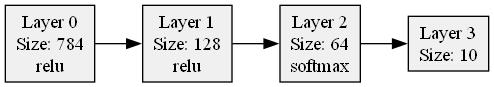

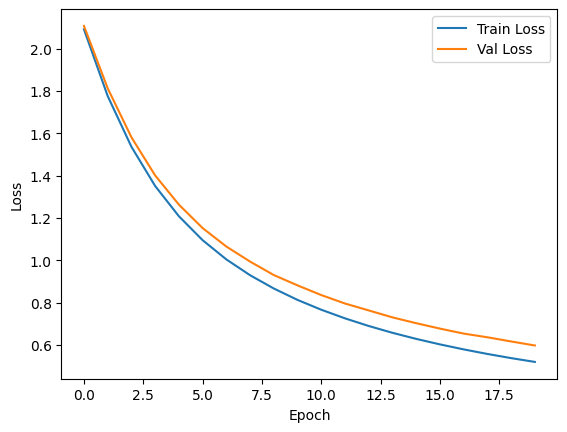

Iteration 1, loss = 1.08637988
Iteration 2, loss = 0.31494149
Iteration 3, loss = 0.18468047
Iteration 4, loss = 0.12082662
Iteration 5, loss = 0.08204947
Iteration 6, loss = 0.05809902
Iteration 7, loss = 0.04218392
Iteration 8, loss = 0.03036946
Iteration 9, loss = 0.02054743
Iteration 10, loss = 0.01543328
Iteration 11, loss = 0.01237439
Iteration 12, loss = 0.00956222
Iteration 13, loss = 0.00793182
Iteration 14, loss = 0.00652515
Iteration 15, loss = 0.00548737
Iteration 16, loss = 0.00472562
Iteration 17, loss = 0.00415007
Iteration 18, loss = 0.00368572
Iteration 19, loss = 0.00322339
Iteration 20, loss = 0.00284658


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


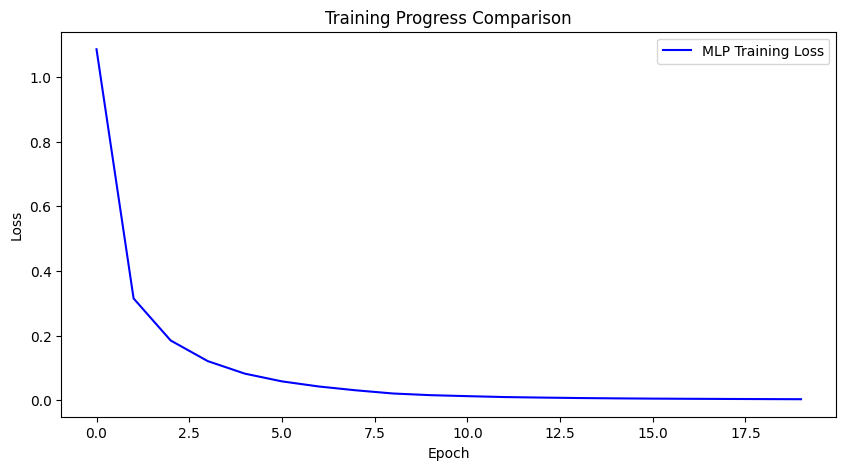

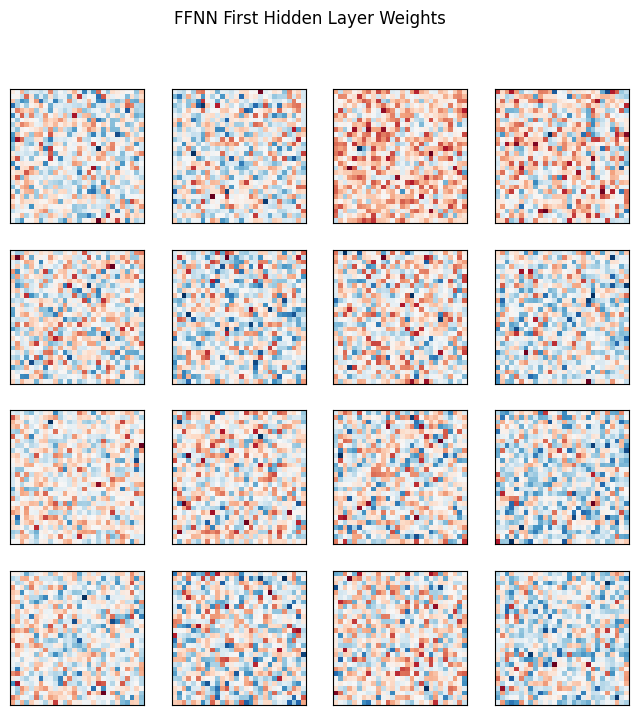


================= Hasil Perbandingan =================
FFNN Test Accuracy: 0.00% | Waktu: 4.76s
MLP Test Accuracy: 93.43% | Waktu: 3.55s


In [10]:

# 3. Implementasi FFNN Kustom
# ==============================
layer_sizes = [784, 128, 64, 10]
activations = ['relu', 'relu', 'softmax']
weight_inits = [
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42},
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42},
    {'method': 'normal', 'mean': 0, 'variance': 0.01, 'seed': 42}
]

t0 = time.time()
ffnn_model = FFNN(
    layer_sizes=layer_sizes,
    activations=activations,
    loss_function='categorical_cross_entropy',
    weight_inits=weight_inits
)


# Konversi label ke one-hot encoding
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_onehot = encoder.transform(y_val.reshape(-1, 1))

# Training
history = ffnn_model.train(
    X_train=X_train,
    y_train=y_train_onehot,
    X_val=X_val,
    y_val=y_val_onehot,
    epochs=20,
    batch_size=128,
    learning_rate=0.01,
    verbose=1
)
ffnn_model.plot_as_graph()

plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluasi
test_pred = ffnn_model.forward(X_test)
test_pred_classes = np.argmax(test_pred, axis=1)
ffnn_accuracy = np.mean(test_pred_classes == y_test)
ffnn_time = time.time() - t0

# 4. Implementasi MLPClassifier
# ==============================
t0 = time.time()
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size=128,
    max_iter=20,
    verbose=True,
    random_state=42
)

mlp_clf.fit(X_train, y_train)
mlp_accuracy = mlp_clf.score(X_test, y_test)
mlp_time = time.time() - t0

# 5. Plotting dan Hasil
# ==============================
# Plot akurasi
plt.figure(figsize=(10, 5))
if hasattr(mlp_clf, 'loss_curve_'):
    plt.plot(mlp_clf.loss_curve_, label='MLP Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Progress Comparison')
plt.legend()
plt.show()

# Plot bobot layer pertama
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.ravel()):
    if i < ffnn_model.layers[0].W.shape[1]:
        ax.imshow(ffnn_model.layers[0].W[:, i].reshape(28, 28), cmap='RdBu_r')
        ax.set_xticks(())
        ax.set_yticks(())
plt.suptitle("FFNN First Hidden Layer Weights")
plt.show()

# Print hasil
print("\n================= Hasil Perbandingan =================")
print(f"FFNN Test Accuracy: {ffnn_accuracy * 100:.2f}% | Waktu: {ffnn_time:.2f}s")
print(f"MLP Test Accuracy: {mlp_accuracy * 100:.2f}% | Waktu: {mlp_time:.2f}s")
print("=======================================================")